# Donor cell level analysis, B cells

**Top Note:** we should consider normalise the library size (labelled as `exp_sum_count` or `total_counts`) with predefined coefficient weight as 1.

$$y \sim NB(\mu, \phi)$$
$$\log(\mu) = w_0 * 1 + w_1 * condition + 1 * total\_counts$$

You may use your implemement and fit this parameter (it should be close enough to 1) or use 
[statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.NegativeBinomial.html)
by setting it as `exposure`:

```Python
NB_glm = sm.discrete.discrete_model.NegativeBinomial(
    obs_y, feature_x,                                                         
    loglike_method = 'nb2', 
    exposure = sample_libsize, 
    offset = None, 
    missing = 'none', 
    check_rank = True
)
```

For negative binomial likelihood, check [aod R package](https://rdrr.io/cran/aod/man/negbin.html).

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.io import mmread
from statsmodels.discrete.discrete_model import NegativeBinomial
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../NegabinGLM')

import NegativeBinomial as NB

In [2]:
# create a repository for the data
!mkdir ../write_data/write_data_donor_B
path = '../write_data/write_data_donor_B/'

## Load genes

In [3]:
df_genes = pd.read_csv('../data/NPC_NLH-genes.tsv', sep='\t')
df_genes

,gene_names,gene_ids
0,HES5,ENSG00000197921
1,TP73,ENSG00000078900
2,HES2,ENSG00000069812
3,PAX7,ENSG00000009709
4,E2F2,ENSG00000007968
...,...,...
614,OLIG1,ENSG00000184221
615,RUNX1,ENSG00000159216
616,ERG,ENSG00000157554
617,ETS2,ENSG00000157557


## Load donor level B cells

In [4]:
df_donor_B = pd.read_csv('../data/NPC_NLH-Bcell-donorX.tsv', sep='\t', index_col=0)
df_donor_B

,condition,cell_number,total_counts,HES5,TP73,HES2,PAX7,E2F2,RUNX3,TFAP2E,...,TEF,SREBF2,GABPA,BACH1,OLIG2,OLIG1,RUNX1,ERG,ETS2,PKNOX1
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,NPC,957,5398577.0,1.0,7.0,0.0,0.0,2.0,213.0,0.0,...,6.0,218.0,105.0,501.0,0.0,0.0,73.0,0.0,13.0,32.0
2,NPC,1577,15724341.0,0.0,18.0,0.0,0.0,24.0,266.0,1.0,...,19.0,178.0,121.0,219.0,0.0,0.0,175.0,0.0,3.0,67.0
3,NPC,1894,5610796.0,0.0,7.0,0.0,0.0,10.0,284.0,4.0,...,4.0,220.0,61.0,188.0,0.0,0.0,58.0,0.0,10.0,38.0
4,NPC,3395,18016842.0,0.0,19.0,0.0,0.0,10.0,723.0,4.0,...,19.0,447.0,248.0,393.0,0.0,0.0,262.0,0.0,30.0,146.0
5,NPC,1652,8721679.0,0.0,25.0,0.0,0.0,40.0,446.0,5.0,...,7.0,358.0,165.0,202.0,0.0,0.0,163.0,1.0,14.0,84.0
9,NPC,3072,24296226.0,0.0,22.0,0.0,0.0,16.0,1030.0,9.0,...,26.0,690.0,376.0,1037.0,0.0,0.0,313.0,0.0,23.0,185.0
10,NPC,2716,12745779.0,0.0,4.0,0.0,0.0,7.0,577.0,5.0,...,23.0,361.0,233.0,317.0,0.0,0.0,280.0,0.0,25.0,100.0
11,NLH,2314,12160524.0,0.0,7.0,0.0,0.0,10.0,523.0,4.0,...,18.0,561.0,190.0,504.0,0.0,0.0,328.0,1.0,30.0,95.0
12,NLH,4149,31006660.0,1.0,29.0,0.0,0.0,22.0,1121.0,5.0,...,33.0,987.0,444.0,1165.0,0.0,0.0,462.0,0.0,29.0,239.0


In [5]:
X_donor_B = df_donor_B[['condition', 'cell_number', 'total_counts']]
X_donor_B

,condition,cell_number,total_counts
patient_ID,,,
1,NPC,957,5398577.0
2,NPC,1577,15724341.0
3,NPC,1894,5610796.0
4,NPC,3395,18016842.0
5,NPC,1652,8721679.0
9,NPC,3072,24296226.0
10,NPC,2716,12745779.0
11,NLH,2314,12160524.0
12,NLH,4149,31006660.0


In [6]:
Y_donor_B = df_donor_B[df_donor_B.columns[3:]]
Y_donor_B

,HES5,TP73,HES2,PAX7,E2F2,RUNX3,TFAP2E,MTF1,POU3F1,ZNF684,...,TEF,SREBF2,GABPA,BACH1,OLIG2,OLIG1,RUNX1,ERG,ETS2,PKNOX1
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,1.0,7.0,0.0,0.0,2.0,213.0,0.0,62.0,1.0,19.0,...,6.0,218.0,105.0,501.0,0.0,0.0,73.0,0.0,13.0,32.0
2,0.0,18.0,0.0,0.0,24.0,266.0,1.0,101.0,8.0,38.0,...,19.0,178.0,121.0,219.0,0.0,0.0,175.0,0.0,3.0,67.0
3,0.0,7.0,0.0,0.0,10.0,284.0,4.0,71.0,4.0,12.0,...,4.0,220.0,61.0,188.0,0.0,0.0,58.0,0.0,10.0,38.0
4,0.0,19.0,0.0,0.0,10.0,723.0,4.0,171.0,9.0,71.0,...,19.0,447.0,248.0,393.0,0.0,0.0,262.0,0.0,30.0,146.0
5,0.0,25.0,0.0,0.0,40.0,446.0,5.0,132.0,5.0,45.0,...,7.0,358.0,165.0,202.0,0.0,0.0,163.0,1.0,14.0,84.0
9,0.0,22.0,0.0,0.0,16.0,1030.0,9.0,309.0,20.0,87.0,...,26.0,690.0,376.0,1037.0,0.0,0.0,313.0,0.0,23.0,185.0
10,0.0,4.0,0.0,0.0,7.0,577.0,5.0,183.0,4.0,74.0,...,23.0,361.0,233.0,317.0,0.0,0.0,280.0,0.0,25.0,100.0
11,0.0,7.0,0.0,0.0,10.0,523.0,4.0,227.0,12.0,48.0,...,18.0,561.0,190.0,504.0,0.0,0.0,328.0,1.0,30.0,95.0
12,1.0,29.0,0.0,0.0,22.0,1121.0,5.0,479.0,17.0,102.0,...,33.0,987.0,444.0,1165.0,0.0,0.0,462.0,0.0,29.0,239.0


filter gene with 0 total counts

In [7]:
# filter out genes with zero counts in all cells
Y_donor_B = Y_donor_B.loc[:, (Y_donor_B != 0).any(axis=0)]
Y_donor_B

,HES5,TP73,E2F2,RUNX3,TFAP2E,MTF1,POU3F1,ZNF684,NFYC,FOXO6,...,MAFF,ATF4,TEF,SREBF2,GABPA,BACH1,RUNX1,ERG,ETS2,PKNOX1
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,1.0,7.0,2.0,213.0,0.0,62.0,1.0,19.0,314.0,0.0,...,16.0,431.0,6.0,218.0,105.0,501.0,73.0,0.0,13.0,32.0
2,0.0,18.0,24.0,266.0,1.0,101.0,8.0,38.0,435.0,0.0,...,20.0,1138.0,19.0,178.0,121.0,219.0,175.0,0.0,3.0,67.0
3,0.0,7.0,10.0,284.0,4.0,71.0,4.0,12.0,305.0,0.0,...,16.0,423.0,4.0,220.0,61.0,188.0,58.0,0.0,10.0,38.0
4,0.0,19.0,10.0,723.0,4.0,171.0,9.0,71.0,875.0,0.0,...,33.0,1525.0,19.0,447.0,248.0,393.0,262.0,0.0,30.0,146.0
5,0.0,25.0,40.0,446.0,5.0,132.0,5.0,45.0,524.0,0.0,...,11.0,600.0,7.0,358.0,165.0,202.0,163.0,1.0,14.0,84.0
9,0.0,22.0,16.0,1030.0,9.0,309.0,20.0,87.0,1410.0,0.0,...,160.0,2114.0,26.0,690.0,376.0,1037.0,313.0,0.0,23.0,185.0
10,0.0,4.0,7.0,577.0,5.0,183.0,4.0,74.0,852.0,0.0,...,18.0,980.0,23.0,361.0,233.0,317.0,280.0,0.0,25.0,100.0
11,0.0,7.0,10.0,523.0,4.0,227.0,12.0,48.0,655.0,0.0,...,41.0,1183.0,18.0,561.0,190.0,504.0,328.0,1.0,30.0,95.0
12,1.0,29.0,22.0,1121.0,5.0,479.0,17.0,102.0,1452.0,2.0,...,86.0,2573.0,33.0,987.0,444.0,1165.0,462.0,0.0,29.0,239.0


change condition to binary

In [8]:
# add a binary condition column, 1 for NPC, 0 for NLH
X_donor_B['condition_bi'] = np.where(X_donor_B['condition']=='NPC', 1, 0)
X_donor_B['log_tc'] = np.log(X_donor_B['total_counts'])
X_donor_B

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_17071/3853983331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_donor_B['condition_bi'] = np.where(X_donor_B['condition']=='NPC', 1, 0)
/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_17071/3853983331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_donor_B['log_tc'] = np.log(X_donor_B['total_counts'])


,condition,cell_number,total_counts,condition_bi,log_tc
patient_ID,,,,,
1,NPC,957,5398577.0,1,15.501646
2,NPC,1577,15724341.0,1,16.570720
3,NPC,1894,5610796.0,1,15.540203
4,NPC,3395,18016842.0,1,16.706818
5,NPC,1652,8721679.0,1,15.981322
9,NPC,3072,24296226.0,1,17.005832
10,NPC,2716,12745779.0,1,16.360711
11,NLH,2314,12160524.0,0,16.313706
12,NLH,4149,31006660.0,0,17.249713


In [9]:
X_donor_B_NB1 = X_donor_B[['condition_bi', 'log_tc']] # X of L1, NB model
X_donor_B_NB0 = X_donor_B[['log_tc']] # X of L0, NB model

X_donor_B_NB0 = sm.add_constant(X_donor_B_NB0)
X_donor_B_NB1 = sm.add_constant(X_donor_B_NB1)

In [41]:
X_donor_B_NB1

,const,condition_bi,log_tc
patient_ID,,,
1,1.0,1,15.501646
2,1.0,1,16.570720
3,1.0,1,15.540203
4,1.0,1,16.706818
5,1.0,1,15.981322
9,1.0,1,17.005832
10,1.0,1,16.360711
11,1.0,0,16.313706
12,1.0,0,17.249713


In [11]:
X_donor_B_exog = X_donor_B[X_donor_B.columns[-1:]]
# add constant column
X_donor_B_exog = sm.add_constant(X_donor_B_exog) # X of L1, statsmodels
X_donor_B_const = X_donor_B_exog[['const']] # X of L0, statsmodels

In [12]:
X_donor_B_tc = X_donor_B[X_donor_B.columns[-2:-1]]
# convert to a 1D array
X_donor_B_tc = X_donor_B_tc.values.ravel()
X_donor_B_tc # exposure in statsmodels, total_counts

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

Fit NegBin models 

L1:
$$\log(\mu) = w_0 * 1 + w_1 * condition + 1 * total\_counts$$
L0 (NULL): 
$$\log(\mu) = w_0 * 1 + 1 * total\_counts$$

The `llr_pvalue` is the p value of the log likelihood ratio test on L0 and L1

In [13]:
ll0_donor_B = np.zeros(Y_donor_B.shape[1])
ll1_donor_B = np.zeros(Y_donor_B.shape[1])

NB_Reg module

In [16]:
'''
test
Y_genes = Y_donor_T.iloc[:, 29]

L1_NB = NB.NB_Reg(X_donor_T_NB1, Y_genes)
L0_NB = NB.NB_Reg(X_donor_T_NB0, Y_genes)
L1_NB.fit_w_exp()
L0_NB.fit_w_exp()
L1_NB.fit_phi()
L0_NB.fit_phi()

params_0 = L0_NB.params
params_1 = L1_NB.params
'''

In [15]:
for i in range(Y_donor_B.shape[1]):

    Y_genes = Y_donor_B.iloc[:, i]

    L1_NB = NB.NB_Reg(X_donor_B_NB1, Y_genes)
    L0_NB = NB.NB_Reg(X_donor_B_NB0, Y_genes)
    
    L1_NB.fit_w_exp()
    L0_NB.fit_w_exp()
    L1_NB.fit_phi()
    L0_NB.fit_phi()

    ll0_donor_B[i] = -1 * L0_NB.optimize_record_phi.fun
    ll1_donor_B[i] = -1 * L1_NB.optimize_record_phi.fun

    if i % 50 == 0:
        print(i)

0


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

50


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

100


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: inva

150


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: inva

200


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

250


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

300


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

350


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

400


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

450


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

In [18]:
'''
for i in range(Y_donor_T.shape[1]):

    Y_genes = Y_donor_T.iloc[:, i]

    try:
        L1 = NegativeBinomial(Y_genes, X_donor_T_exog, exposure=X_donor_T_tc).fit(method='newton', disp=False, maxiter=25)
        L0 = NegativeBinomial(Y_genes, X_donor_T_const, exposure=X_donor_T_tc).fit(method='newton', disp=False, maxiter=25)

        ll0_donor_T[i] = L0.llf
        ll1_donor_T[i] = L1.llf

    except np.linalg.LinAlgError:
        print('LinAlgError: Singular matrix encountered')

'''


"\nfor i in range(Y_donor_T.shape[1]):\n\n    Y_genes = Y_donor_T.iloc[:, i]\n\n    try:\n        L1 = NegativeBinomial(Y_genes, X_donor_T_exog, exposure=X_donor_T_tc).fit(method='newton', disp=False, maxiter=25)\n        L0 = NegativeBinomial(Y_genes, X_donor_T_const, exposure=X_donor_T_tc).fit(method='newton', disp=False, maxiter=25)\n\n        ll0_donor_T[i] = L0.llf\n        ll1_donor_T[i] = L1.llf\n\n    except np.linalg.LinAlgError:\n        print('LinAlgError: Singular matrix encountered')\n\n"

In [19]:
'''
# find 0 in ll0, error genes
error_genes_donor_T = []
for i in range(len(ll0_donor_T)):
    if ll0_donor_T[i] == 0:
        error_genes_donor_T.append(i)
'''

'\n# find 0 in ll0, error genes\nerror_genes_donor_T = []\nfor i in range(len(ll0_donor_T)):\n    if ll0_donor_T[i] == 0:\n        error_genes_donor_T.append(i)\n'

LRT

In [16]:
lrt_statistic_donor_B = 2 * (ll1_donor_B - ll0_donor_B)
p_val_donor_B = sp.stats.chi2.sf(lrt_statistic_donor_B, 1)
p_val_donor_B

array([8.04817707e-01, 1.63974163e-01, 5.56899521e-01, 1.00000000e+00,
       8.73196940e-01, 1.00000000e+00, 1.00000000e+00, 8.91415187e-01,
       1.00000000e+00, 8.13177367e-02, 1.16357510e-01, 6.75522088e-01,
       1.00000000e+00, 3.60383908e-01, 1.01821956e-01, 1.36895072e-01,
       1.00000000e+00, 7.92152970e-01, 1.65938000e-01, 9.18148273e-01,
       1.00000000e+00, 5.17311007e-16, 1.93068585e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 3.30634184e-01, 9.98489755e-01,
       2.11953788e-01, 1.00000000e+00, 3.15003245e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.30824629e-01,
       9.99853065e-01, 3.70785166e-01, 5.11460162e-01, 1.87686996e-02,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.62965869e-01, 1.00000000e+00, 3.12422921e-01, 4.83890822e-01,
       5.10948827e-04, 1.00000000e+00, 3.30634184e-01, 3.12190783e-01,
       3.15003245e-01, 5.49196326e-01, 1.00000000e+00, 9.36445360e-01,
      

In [17]:
from statsmodels.stats.multitest import fdrcorrection
p_val_corrected_donor_B = fdrcorrection(p_val_donor_B, alpha=0.05, method='indep', is_sorted=False)[1]
p_val_corrected_donor_B.shape

(474,)

In [18]:
# create a dataframe, store gene names, p values, and corrected p values
# use gene names from Y_donor_B
df_pval_donor_B = pd.DataFrame({'gene': Y_donor_B.columns, 'p_val': p_val_donor_B, 'p_val_corrected': p_val_corrected_donor_B})

In [19]:
# rank genes by p_val_corrected, ascending order
df_pval_donor_B = df_pval_donor_B.sort_values(by=['p_val_corrected'])
df_pval_donor_B

,gene,p_val,p_val_corrected
350,NR1D1,4.859314e-20,2.303315e-17
209,ZNF16,4.713794e-19,1.117169e-16
440,ZNF701,1.337329e-18,2.112980e-16
460,HIC2,6.576910e-18,7.793639e-16
239,ESRRA,1.491087e-16,1.413551e-14
...,...,...,...
179,TFE3,9.994483e-01,1.000000e+00
178,ELK1,1.000000e+00,1.000000e+00
176,ZBED1,1.000000e+00,1.000000e+00
187,ZNF449,6.354323e-01,1.000000e+00


Plot the distribution of corrected p values

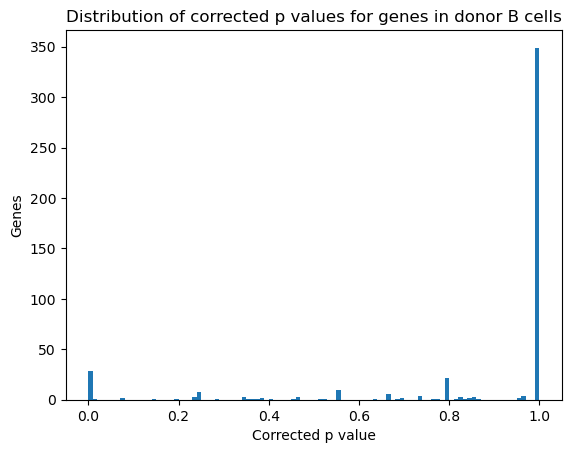

In [20]:
# bar plot the p_val_corrected
genes = np.linspace(1, len(df_pval_donor_B), len(df_pval_donor_B))
plt.hist(df_pval_donor_B['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in donor B cells')
plt.savefig(path + 'p_val_corrected_donor_B.png')
plt.show()

In [21]:
# filter genes with corrected p value = 1
df_pval_donor_B_filtered = df_pval_donor_B[df_pval_donor_B['p_val_corrected'] != 1]
df_pval_donor_B_filtered

,gene,p_val,p_val_corrected
350,NR1D1,4.859314e-20,2.303315e-17
209,ZNF16,4.713794e-19,1.117169e-16
440,ZNF701,1.337329e-18,2.112980e-16
460,HIC2,6.576910e-18,7.793639e-16
239,ESRRA,1.491087e-16,1.413551e-14
...,...,...,...
84,ZIC4,3.150032e-01,9.966649e-01
381,RAX,3.124229e-01,9.966649e-01
51,MEIS1,3.121908e-01,9.966649e-01
26,RXRG,3.306342e-01,9.982204e-01


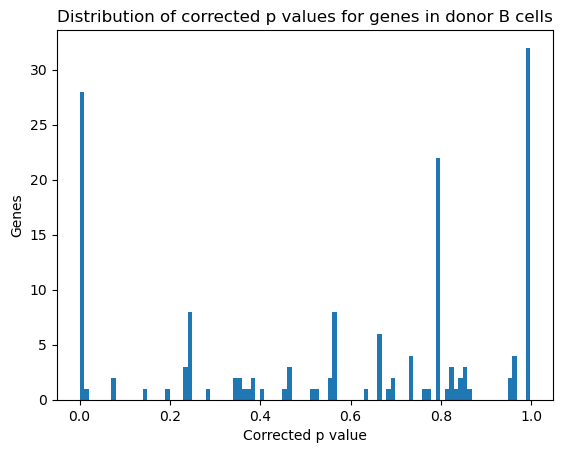

In [22]:
# bar plot the p_val_corrected
genes = np.linspace(1, len(df_pval_donor_B_filtered), len(df_pval_donor_B_filtered))
plt.hist(df_pval_donor_B_filtered['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in donor B cells')
plt.show()

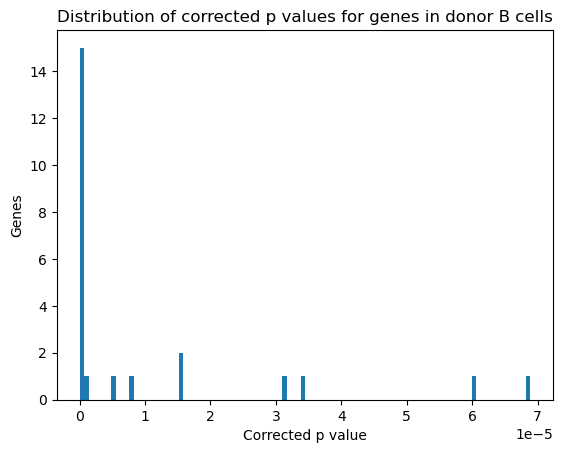

In [23]:
df_pval_donor_B_filtered = df_pval_donor_B_filtered[df_pval_donor_B_filtered['p_val_corrected'] < 0.0001]
genes = np.linspace(1, len(df_pval_donor_B_filtered), len(df_pval_donor_B_filtered))
plt.hist(df_pval_donor_B_filtered['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in donor B cells')
plt.savefig(path + 'p_val_corrected_donor_B_filtered.png')
plt.show()

In [40]:
top_genes_donor_B = df_pval_donor_B_filtered[df_pval_donor_B_filtered['p_val_corrected'] < 2e-5]
top_genes_donor_B

,gene,p_val,p_val_corrected
350,NR1D1,4.859314e-20,2.303315e-17
209,ZNF16,4.713794e-19,1.117169e-16
440,ZNF701,1.337329e-18,2.112980e-16
460,HIC2,6.576910e-18,7.793639e-16
239,ESRRA,1.491087e-16,1.413551e-14
21,ETV3,5.173110e-16,4.086757e-14
136,NFYA,3.212034e-15,2.175006e-13
266,POU6F1,9.767039e-15,5.786971e-13
182,FOXO4,3.127319e-14,1.647055e-12
289,ZNF140,1.223337e-11,5.798618e-10


In [46]:
# find df_donor_B columns that correspond to the top genes, keep condition
df_donor_B_top_genes = df_donor_B[top_genes_donor_B['gene']]
df_donor_B_top_genes['condition'] = df_donor_B['condition']
# move condition column to the front
cols = df_donor_B_top_genes.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_donor_B_top_genes = df_donor_B_top_genes[cols]
df_donor_B_top_genes #final top gene result

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_17071/3143538034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_donor_B_top_genes['condition'] = df_donor_B['condition']


,condition,NR1D1,ZNF16,ZNF701,HIC2,ESRRA,ETV3,NFYA,POU6F1,FOXO4,...,TFAP2A,RREB1,HOXB6,SOX15,HESX1,TEAD3,SOX2,KLF1,BARX2,VENTX
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,NPC,14.0,19.0,32.0,16.0,23.0,50.0,55.0,12.0,5.0,...,2.0,52.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NPC,64.0,35.0,57.0,37.0,58.0,57.0,92.0,17.0,13.0,...,3.0,86.0,5.0,0.0,1.0,4.0,2.0,1.0,2.0,1.0
3,NPC,20.0,11.0,40.0,22.0,26.0,45.0,42.0,7.0,8.0,...,0.0,37.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0
4,NPC,84.0,54.0,163.0,38.0,98.0,162.0,136.0,23.0,21.0,...,8.0,199.0,2.0,0.0,1.0,2.0,4.0,3.0,2.0,1.0
5,NPC,21.0,29.0,95.0,22.0,51.0,44.0,70.0,6.0,10.0,...,3.0,114.0,3.0,1.0,2.0,2.0,2.0,2.0,0.0,3.0
9,NPC,95.0,75.0,188.0,59.0,113.0,229.0,213.0,31.0,20.0,...,7.0,252.0,6.0,2.0,4.0,1.0,1.0,1.0,5.0,2.0
10,NPC,58.0,60.0,161.0,36.0,78.0,114.0,150.0,24.0,20.0,...,5.0,168.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0
11,NLH,80.0,62.0,122.0,47.0,44.0,133.0,130.0,17.0,17.0,...,0.0,157.0,1.0,2.0,4.0,1.0,1.0,0.0,0.0,0.0
12,NLH,141.0,123.0,229.0,94.0,165.0,279.0,324.0,28.0,39.0,...,4.0,356.0,2.0,4.0,6.0,2.0,2.0,0.0,0.0,1.0


In [47]:
# save the top genes to a tsv file
df_donor_B_top_genes.to_csv(path + 'NPC_NLH_donor_B_top_genes.tsv', sep='\t')
top_genes_donor_B.to_csv( path + 'NPC_NLH_donor_B_top_genes_ranking.tsv', sep='\t')

In [48]:
# add total_counts column, total_counts = sum of counts of all genes
df_donor_B_top_genes['total_counts'] = df_donor_B_top_genes.sum(axis=1)
# df_donor_B_top_genes['total_counts'] = df_donor_B['total_counts']
df_donor_B_top_genes

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_17071/2328838305.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_donor_B_top_genes['total_counts'] = df_donor_B_top_genes.sum(axis=1)


,condition,NR1D1,ZNF16,ZNF701,HIC2,ESRRA,ETV3,NFYA,POU6F1,FOXO4,...,RREB1,HOXB6,SOX15,HESX1,TEAD3,SOX2,KLF1,BARX2,VENTX,total_counts
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,NPC,14.0,19.0,32.0,16.0,23.0,50.0,55.0,12.0,5.0,...,52.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,359.0
2,NPC,64.0,35.0,57.0,37.0,58.0,57.0,92.0,17.0,13.0,...,86.0,5.0,0.0,1.0,4.0,2.0,1.0,2.0,1.0,647.0
3,NPC,20.0,11.0,40.0,22.0,26.0,45.0,42.0,7.0,8.0,...,37.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,305.0
4,NPC,84.0,54.0,163.0,38.0,98.0,162.0,136.0,23.0,21.0,...,199.0,2.0,0.0,1.0,2.0,4.0,3.0,2.0,1.0,1198.0
5,NPC,21.0,29.0,95.0,22.0,51.0,44.0,70.0,6.0,10.0,...,114.0,3.0,1.0,2.0,2.0,2.0,2.0,0.0,3.0,577.0
9,NPC,95.0,75.0,188.0,59.0,113.0,229.0,213.0,31.0,20.0,...,252.0,6.0,2.0,4.0,1.0,1.0,1.0,5.0,2.0,1621.0
10,NPC,58.0,60.0,161.0,36.0,78.0,114.0,150.0,24.0,20.0,...,168.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,1073.0
11,NLH,80.0,62.0,122.0,47.0,44.0,133.0,130.0,17.0,17.0,...,157.0,1.0,2.0,4.0,1.0,1.0,0.0,0.0,0.0,970.0
12,NLH,141.0,123.0,229.0,94.0,165.0,279.0,324.0,28.0,39.0,...,356.0,2.0,4.0,6.0,2.0,2.0,0.0,0.0,1.0,2133.0


heatmap

In [49]:
# sum the counts of the top genes for condition NPC and NLH, normalize each gene
df_donor_B_top_genes_heatmap = df_donor_B_top_genes.groupby('condition').sum()
# normalize each gene by dividing each gene by total_counts
df_donor_B_top_genes_heatmap = df_donor_B_top_genes_heatmap.div(df_donor_B_top_genes_heatmap['total_counts'], axis=0)
# drop total_counts column
df_donor_B_top_genes_heatmap = df_donor_B_top_genes_heatmap.drop(columns=['total_counts'])
df_donor_B_top_genes_heatmap

,NR1D1,ZNF16,ZNF701,HIC2,ESRRA,ETV3,NFYA,POU6F1,FOXO4,ZNF140,TFAP2A,RREB1,HOXB6,SOX15,HESX1,TEAD3,SOX2,KLF1,BARX2,VENTX
condition,,,,,,,,,,,,,,,,,,,,
NLH,0.070435,0.056733,0.102119,0.047099,0.065297,0.160779,0.149647,0.013916,0.018626,0.150289,0.002141,0.155641,0.000856,0.002141,0.002141,0.000856,0.000642,0.000428,0.00000,0.000214
NPC,0.061592,0.048962,0.127336,0.039792,0.077336,0.121280,0.131142,0.020761,0.016782,0.178374,0.004844,0.157093,0.003460,0.001384,0.001730,0.002076,0.001557,0.001384,0.00173,0.001384


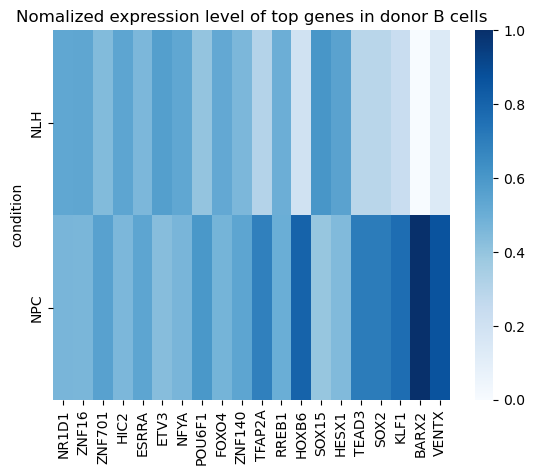

In [50]:
df_donor_B_top_genes_heatmap = df_donor_B_top_genes_heatmap.div(df_donor_B_top_genes_heatmap.sum(axis=0), axis=1)

# heatmap
sns.heatmap(df_donor_B_top_genes_heatmap, cmap='Blues')
plt.title('Nomalized expression level of top genes in donor B cells')
plt.savefig(path + 'top_genes_donor_B_heatmap.png')
plt.show()